In [1]:
import numpy as np
import pandas as pd
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [3]:
random.seed(1)
test_index = random.sample(range(train.shape[0]), 5000)
train_index = list(set(range(train.shape[0])) - set(test_index))
my_train = train.ix[train_index]
my_test = train.ix[test_index]
print(my_train.shape)
print(my_test.shape)

(37000, 785)
(5000, 785)


In [4]:
train_labels = train[[0]].values.ravel()
my_train_labels = my_train[[0]].values.ravel()
my_test_labels = my_test[[0]].values.ravel()
print(len(train_labels))
print(len(my_train_labels))
print(len(my_test_labels))

42000
37000
5000


In [5]:
train_images = train.iloc[:,1:].values
test_images = test.iloc[:,:].values
my_train_images = my_train.iloc[:,1:].values
my_test_images = my_test.iloc[:,1:].values

train_images = train_images.astype(np.float)
test_images = test_images.astype(np.float)
my_train_images = my_train_images.astype(np.float)
my_test_images = my_test_images.astype(np.float)

train_images = np.multiply(train_images, 1.0 / 255.0)
test_images = np.multiply(test_images, 1.0 / 255.0)
my_train_images = np.multiply(my_train_images, 1.0 / 255.0)
my_test_images = np.multiply(my_test_images, 1.0 / 255.0)

In [6]:
def imaginize(row):
    one_image = row.reshape(28,28)
    return one_image

In [7]:
def display(row):
    one_image = imaginize(row)
    plt.imshow(one_image, cmap=cm.binary)

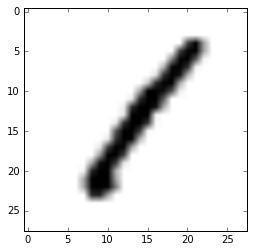

In [8]:
display(my_train_images[0])

In [9]:
# code modified from http://docs.opencv.org/master/dd/d3b/tutorial_py_svm_opencv.html#gsc.tab=0
def deskew(row):
    img = imaginize(row)
    SZ = 28 #size of the image
    affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

In [10]:
def display2(img):
    one_image = imaginize(img)
    plt.figure(1)
    plt.subplot(121)
    plt.imshow(one_image, cmap=cm.binary)
    a = deskew(one_image)
    plt.subplot(122)
    plt.imshow(a, cmap=cm.binary)

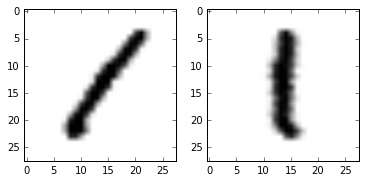

In [11]:
display2(my_train_images[0])

In [12]:
train_deskewed = train_images
test_deskewed = test_images
my_train_deskewed = my_train_images
my_test_deskewed = my_test_images
for i in range(train_images.shape[0]):
    train_deskewed[i] = deskew(train_images[i]).ravel()
for i in range(test_images.shape[0]):
    test_deskewed[i] = deskew(test_images[i]).ravel()
for i in range(my_train_images.shape[0]):
    my_train_deskewed[i] = deskew(my_train_images[i]).ravel()
for i in range(my_test_images.shape[0]):
    my_test_deskewed[i] = deskew(my_test_images[i]).ravel()

In [13]:
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import metrics

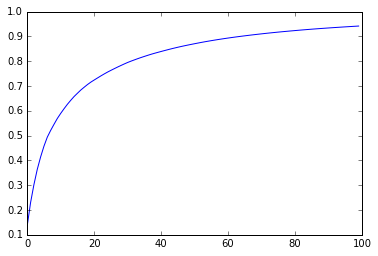

In [14]:
# learn on orig image
pca = PCA(n_components=100)
pca.fit(my_train_images)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [15]:
my_train_reduced = pca.transform(my_train_images)
my_test_reduced = pca.transform(my_test_images)
print(my_train_reduced.shape)
print(my_test_reduced.shape)

(37000, 100)
(5000, 100)


In [16]:
classifier = svm.SVC(gamma=0.001)
classifier.fit(my_train_reduced, my_train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
predicted = classifier.predict(my_test_reduced)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(my_test_labels, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(my_test_labels, predicted))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.95      0.98      0.96       473
          1       0.98      0.99      0.99       553
          2       0.94      0.95      0.95       506
          3       0.96      0.95      0.95       523
          4       0.92      0.97      0.94       480
          5       0.94      0.95      0.95       457
          6       0.98      0.96      0.97       503
          7       0.98      0.96      0.97       498
          8       0.96      0.92      0.94       506
          9       0.93      0.91      0.92       501

avg / total       0.95      0.95      0.95      5000


Confusion matrix:
[[462   0   0   1   1   4   1   0   4   0]
 [  0 548   1   1   0   0   1   0   0 

In [18]:
# learn on deskewed image
pca = PCA(n_components=100)
pca.fit(my_train_deskewed)
my_train_reduced = pca.transform(my_train_deskewed)
my_test_reduced = pca.transform(my_test_deskewed)
classifier = svm.SVC(gamma=0.001)
classifier.fit(my_train_reduced, my_train_labels)
predicted = classifier.predict(my_test_reduced)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(my_test_labels, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(my_test_labels, predicted))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.95      0.98      0.96       473
          1       0.98      0.99      0.99       553
          2       0.94      0.95      0.95       506
          3       0.96      0.95      0.95       523
          4       0.92      0.97      0.94       480
          5       0.94      0.95      0.95       457
          6       0.98      0.96      0.97       503
          7       0.98      0.96      0.97       498
          8       0.96      0.92      0.94       506
          9       0.93      0.91      0.92       501

avg / total       0.95      0.95      0.95      5000


Confusion matrix:
[[462   0   0   1   1   4   1   0   4   0]
 [  0 548   1   1   0   0   1   0   0 

In [ ]:
# use the entire training set to train
pca = PCA(n_components=100)
pca.fit(train_images)
train_reduced = pca.transform(train_images)
test_reduced = pca.transform(test_images)
print(train_reduced.shape)
print(test_reduced.shape)

In [ ]:
classifier = svm.SVC(gamma=0.001)
classifier.fit(train_reduced, train_labels)

In [ ]:
predicted = classifier.predict(test_reduced)

In [ ]:
df = pd.DataFrame(index=range(len(predicted)), columns=['ImageId','Label'])

In [ ]:
df['ImageId'] = range(1, len(predicted)+1)
df['Label'] = predicted

In [ ]:
df.to_csv('pred.csv', sep=',', idne)